In [1]:
## headings
"""
made by weiyw @ 2019-03-08
made to use the deep Spatio-temporal Residual Network
"""
# from __future__ import print_function
# from preprocessing import *
# import numpy as np
# np.random.seed(2333)  # for reproducibility


import os
import time
import struct
import numpy as np
import h5py

import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# from STResNet import stresnet
import metrics as metrics

# from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_min_nonzero_value(data_in, init_min = 1):
    min_value = init_min
    for bb in data_in:
        for aa in bb:
            if abs(aa) < min_value and aa != 0:
                min_value = abs(aa)
    return min_value

In [3]:
# def prepare_data(filepath, all_times, data_step, data_stride):
#     X = []
#     y = []
#     for i in range(all_times):
#         count_X = range(i*data_stride, i*data_stride + data_step)
#         for j in count_X:
#             img = Image.open(filepath + "/" + str(j+1)+".png")
#             data = np.resize(np.asarray(img), (330, 580, 4))#np.asarray(img)
#             X.append(data[:,:,0])
#         count_y = i*data_stride + data_step
#         img = Image.open(filepath + "/" + str(count_y+1)+".png")
#         data = np.resize(np.asarray(img), (330, 580, 4))#np.asarray(img)
#         y.append(data[:,:,0])
#     X = np.array(X, dtype='float32')
#     y = np.array(y, dtype='float32')
#     return X, y

In [4]:
def get_bindata(data_path, data_index, data_phase, nt, nr):
    # data_index start from 1
    model_num = int( ( int(data_index) - 1 ) / 51) + 1
    source_num = ( int(data_index) - 1 ) % 51 + 1
    data_name = data_path + "/model" + str(model_num) + "source" + str(source_num) + data_phase + ".bin"
#     print(data_name)
    
    out_data = np.empty((nt,nr))
    FA = open(data_name, "rb")
    FA.seek(3232,0)
    for tt in range(nt):
        for rr in range(nr):
            data = FA.read(4)
            data_float = struct.unpack("f", data)[0]
            out_data[tt][rr] = data_float
     #np.shape(out_data)   # (4000,301)
#     cut_data = out_data[0:4000, 8:401]
    return out_data  

In [5]:
havebatch = True

In [6]:
## loadin data
ts = time.time()
# data_path = "./mydata/first_test/"
# data_path = "/media/wywdisk/VSPdata/data/layer2_1-90_rightPML"
data_path = "/media/wywdisk/VSPdata/data/haveinvx/layer2_haveinvx"

## count the total number in one data_path
# datapath_list = os.listdir( os.path.join(data_path,'vz') )
# datapath_list.sort()
# totalNum = len(datapath_list)
# print(totalNum)

data_phases = ["vz", "vx"]
nph = len(data_phases)     # phase number
nt = 4000     # time step
nr = 300      # receiver
ns = 51       # shot
nmodel = 1    # batch
'''
2D conv, (batch, 4000, 300, 2) channels_last
'''
if havebatch:
    ## prepare files
    one_piece = np.empty((nmodel,nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 1
    for data_phase in data_phases:
        p_flag = int(data_phase == 'vx')      # vz=0, vx=1
        one_piece[0,:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 


    valid_piece = np.empty((nmodel,nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 2
    for data_phase in data_phases:
        p_flag = int(data_phase == 'vx')      # vz=0, vx=1
        valid_piece[0,:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

    test_piece = np.empty((nmodel,nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 3
    for data_phase in data_phases:
        p_flag = int(data_phase == 'vx')      # vz=0, vx=1
        test_piece[0,:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

else:    
    ## prepare files
    one_piece = np.empty((nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 1
    for data_phase in data_phases:
        p_flag = int(data_phase == 'vx')      # vz=0, vx=1
        one_piece[:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 


    valid_piece = np.empty((nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 2
    for data_phase in data_phases:
        p_flag = int(data_phase == 'vx')      # vz=0, vx=1
        valid_piece[:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

    test_piece = np.empty((nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 3
    for data_phase in data_phases:
        p_flag = int(data_phase == 'vx')      # vz=0, vx=1
        test_piece[:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 


print("\nelapsed time (compiling model): %.3f seconds\n" %
        (time.time() - ts))


elapsed time (compiling model): 3.123 seconds



In [7]:
## loadin data
ts = time.time()
# data_path = "./mydata/first_test/"
# data_path = "/media/wywdisk/VSPdata/data/layer2_1-90_rightPML"
data_path = "/media/wywdisk/VSPdata/data/haveinvx/layer2_haveinvx"

## count the total number in one data_path
# datapath_list = os.listdir( os.path.join(data_path,'vz') )
# datapath_list.sort()
# totalNum = len(datapath_list)
# print(totalNum)

data_phases = ["div", "curl"]
nph = len(data_phases)     # phase number
nt = 4000     # time step
nr = 300      # receiver
ns = 51       # shot
nmodel = 1    # batch
'''
2D conv, (batch, 4000, 300, 2) channels_last
'''
if havebatch :
    ## prepare files
    one_piece_y = np.empty((nmodel,nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 1
    for data_phase in data_phases:
        p_flag = int(data_phase == 'curl')      # vz=0, vx=1
        one_piece_y[0,:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

    ## prepare files
    valid_piece_y = np.empty((nmodel,nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 2
    for data_phase in data_phases:
        p_flag = int(data_phase == 'curl')      # vz=0, vx=1
        valid_piece_y[0,:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

    ## prepare files
    test_piece_y = np.empty((nmodel,nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 10    # for iteration [1, totalNum]
    data_index = 3
    for data_phase in data_phases:
        p_flag = int(data_phase == 'curl')      # vz=0, vx=1
        test_piece_y[0,:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 


else:
    ## prepare files
    one_piece_y = np.empty((nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 1
    for data_phase in data_phases:
        p_flag = int(data_phase == 'curl')      # vz=0, vx=1
        one_piece_y[:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

    ## prepare files
    valid_piece_y = np.empty((nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 1    # for iteration [1, totalNum]
    data_index = 2
    for data_phase in data_phases:
        p_flag = int(data_phase == 'curl')      # vz=0, vx=1
        valid_piece_y[:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

    ## prepare files
    test_piece_y = np.empty((nt, nr, nph)) # 4000, 300, 2, 51
    # model_count = 10    # for iteration [1, totalNum]
    data_index = 3
    for data_phase in data_phases:
        p_flag = int(data_phase == 'curl')      # vz=0, vx=1
        test_piece_y[:,:,p_flag] = get_bindata(os.path.join(data_path, data_phase), data_index, data_phase, nt, nr) 

print("\nelapsed time (compiling model): %.3f seconds\n" %
        (time.time() - ts)) 


elapsed time (compiling model): 3.019 seconds



In [8]:
# ## check for input data
# show_data = one_piece[:,:,0,0]
# # show_data = this_data[0]
# target = "show_data" #"this_data[0]"
# print "The shape of ", target, "\tis", eval(target).shape
# print "The max:\t",  eval(target).max(), "\tThe min:\t",  eval(target).min()
# print "The mean:\t",  eval(target).mean(), "\tThe std:\t",  eval(target).std()
# print "The absolute minimal value is\t", get_min_nonzero_value(eval(target))
# print "==========================================================================="
# show_data = one_piece[:,:,1,0]
# # show_data = this_data[1]
# target = "show_data" #"this_data[0]"
# print "The shape of ", target, "\tis", eval(target).shape
# print "The max:\t",  eval(target).max(), "\tThe min:\t",  eval(target).min()
# print "The mean:\t",  eval(target).mean(), "\tThe std:\t",  eval(target).std()
# print "The absolute minimal value is\t", get_min_nonzero_value(eval(target))

In [9]:
## prepare data for input
## 如何迭代输入数据？
# this_data_3d = one_piece.reshape((nt*nph,nr,ns))
# indata = tf.convert_to_tensor(this_data_3d)

# this_data_5d = one_piece #.reshape((nt*nph,nr,ns))
# indata = tf.convert_to_tensor(this_data_5d)

In [10]:
ts = time.time()
x_train, y_train = tf.convert_to_tensor(one_piece), tf.convert_to_tensor(one_piece_y)
x_valid, y_valid = tf.convert_to_tensor(valid_piece), tf.convert_to_tensor(valid_piece_y)
x_test, y_test = tf.convert_to_tensor(test_piece), tf.convert_to_tensor(test_piece_y)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)
print("\nelapsed time (compiling model): %.3f seconds\n" %
        (time.time() - ts)) 

(1, 4000, 300, 2)
(1, 4000, 300, 2)
(1, 4000, 300, 2)
(1, 4000, 300, 2)
(1, 4000, 300, 2)
(1, 4000, 300, 2)

elapsed time (compiling model): 0.477 seconds



In [11]:
## network workflow
import keras
from keras.models import Model
from keras.layers.convolutional import Convolution2D
# from keras.layers.convolutional import Conv3d
from keras.layers.convolutional import Conv3D
from keras.layers.normalization import BatchNormalization
from keras.layers import (
    Input,
    Activation,
    merge,
    Dense,
    Reshape
)
x_input = Input( shape=( nt, nr, nph) )##one_piece
conv1 = Convolution2D(
    nb_filter=64, nb_row=3, nb_col=3, border_mode="same", data_format="channels_last")(x_input)
conv1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                           beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                           moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                           beta_constraint=None, gamma_constraint=None)(conv1)
conv2 = Convolution2D(
    nb_filter=2, nb_row=3, nb_col=3, border_mode="same", data_format="channels_last")(conv1)


# conv1 = Conv3D(filters=51, kernel_size=(2,2,2), strides=(1,1,1), 
#                             padding='same', data_format="channels_last", dilation_rate=(1,1,1),
#                            activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#                            bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#                            activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x_input)
# conv1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                            beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
#                            moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                            beta_constraint=None, gamma_constraint=None)(conv1)
# conv2 = Conv3D(filters=51, kernel_size=(2,2,2), strides=(1,1,1), 
#                             padding='same', data_format="channels_last", dilation_rate=(1,1,1),
#                            activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#                            bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#                            activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(conv1)

# conv2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                            beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
#                            moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                            beta_constraint=None, gamma_constraint=None)(conv2)

# conv3 = Conv3D(filters=51, kernel_size=(2,2,2), strides=(1,1,1), 
#                             padding='same', data_format="channels_last", dilation_rate=(1,1,1),
#                            activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#                            bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#                            activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(conv2)
# conv3 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                            beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
#                            moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                            beta_constraint=None, gamma_constraint=None)(conv3)

# convLSTM_1 = keras.layers.ConvLSTM2D(filters=51, kernel_size=(2,2), strides=(1, 1), padding='valid', 
#                                      data_format='channels_last', dilation_rate=(1, 1), activation='tanh', 
#                                      recurrent_activation='hard_sigmoid', use_bias=True,
#                                      kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#                                      bias_initializer='zeros', unit_forget_bias=True, 
#                                      kernel_regularizer=None, recurrent_regularizer=None, 
#                                      bias_regularizer=None, activity_regularizer=None, 
#                                      kernel_constraint=None, recurrent_constraint=None, 
#                                      bias_constraint=None, return_sequences=True, 
#                                      go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0)(conv3)

# model = Model(inputs=x_input, outputs=convLSTM_1)
# main_output = conv2[0]
model = Model(inputs=x_input, outputs=conv2)
model.summary()

/home/wyw/anaconda3/envs/tf-keras/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(data_format="channels_last", kernel_size=(3, 3), filters=64, padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4000, 300, 2)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4000, 300, 64)     1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000, 300, 64)     256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4000, 300, 2)      1154      
Total params: 2,626
Trainable params: 2,498
Non-trainable params: 128
_________________________________________________________________


/home/wyw/anaconda3/envs/tf-keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(data_format="channels_last", kernel_size=(3, 3), filters=2, padding="same")`


In [12]:
# ## model-class
# '''
# STrans-ResNet: Deep Spatial transform with time Residual Networks
# modified by weiyw @ 2019-04-02 from ST-ResNet
# '''
# from __future__ import print_function
# from keras.layers import (
#     Input,
#     Activation,
#     merge,
#     Dense,
#     Reshape
# )
# from keras.layers.convolutional import Convolution2D
# from keras.layers.normalization import BatchNormalization
# from keras.models import Model
# #from keras.utils.visualize_util import plot


# def _shortcut(input, residual):
#     return merge([input, residual], mode='sum')


# def _bn_relu_conv(nb_filter, nb_row, nb_col, subsample=(1, 1), bn=False):
#     def f(input):
#         if bn:
#             input = BatchNormalization(mode=0, axis=1)(input) ## attention!!
#         activation = Activation('relu')(input)
#         return Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample, border_mode="same")(activation)
#     return f


# def _residual_unit(nb_filter, init_subsample=(1, 1)):
#     def f(input):
#         residual = _bn_relu_conv(nb_filter, 3, 3)(input)
#         residual = _bn_relu_conv(nb_filter, 3, 3)(residual)
#         return _shortcut(input, residual)
#     return f


# def ResUnits(residual_unit, nb_filter, repetations=1):
#     def f(input):
#         for i in range(repetations):
#             init_subsample = (1, 1)
#             input = residual_unit(nb_filter=nb_filter,
#                                   init_subsample=init_subsample)(input)
#         return input
#     return f


# # def stresnet(c_conf=(3, 2, 32, 32), p_conf=(3, 2, 32, 32), t_conf=(3, 2, 32, 32), external_dim=8, nb_residual_unit=3):
# def stresnet(total_conf=(4000, 2, 300, 51), external_dim=None, nb_residual_unit=3):
#     '''
#     C - Temporal Closeness
#     P - Period
#     T - Trend
#     conf = (len_seq, nb_flow, map_height, map_width)
#     external_dim
#     '''
#     # main input
#     main_inputs = []
#     outputs = []
#     for conf in [total_conf] :#[c_conf, p_conf, t_conf]:
#         if conf is not None:
#             len_seq, nb_flow, map_height, map_width = conf
#             input = Input(shape=(nb_flow * len_seq, map_height, map_width))
#             main_inputs.append(input)
#             # Conv1
# #             conv1 = Convolution2D(
# #                 nb_filter=64, nb_row=2, nb_col=2, border_mode="same")(input)
#             conv1 = Convolution2D(
#                 nb_filter=64, nb_row=3, nb_col=3, border_mode="same")(input)
#             # [nb_residual_unit] Residual Units
#             residual_output = ResUnits(_residual_unit, nb_filter=64,
#                               repetations=nb_residual_unit)(conv1)
#             # Conv2
#             activation = Activation('relu')(residual_output)
#             conv2 = Convolution2D(
#                 nb_filter=nb_flow, nb_row=3, nb_col=3, border_mode="same")(activation)
# #             conv2 = Convolution2D(
# #                 nb_filter=nb_flow, nb_row=2, nb_col=2, border_mode="same")(activation)

#             outputs.append(conv2)

#     # parameter-matrix-based fusion
#     if len(outputs) == 1:
#         main_output = outputs[0]
#     else:
#         from .iLayer import iLayer
#         new_outputs = []
#         for output in outputs:
#             new_outputs.append(iLayer()(output))
#         main_output = merge(new_outputs, mode='sum')

#     # fusing with external component
#     if external_dim != None and external_dim > 0:
#         # external input
#         external_input = Input(shape=(external_dim,))
#         main_inputs.append(external_input)
#         embedding = Dense(output_dim=10)(external_input)
#         embedding = Activation('relu')(embedding)
#         h1 = Dense(output_dim=nb_flow * map_height * map_width)(embedding)
#         activation = Activation('relu')(h1)
#         external_output = Reshape((nb_flow, map_height, map_width))(activation)
#         main_output = merge([main_output, external_output], mode='sum')
#     else:
#         print('external_dim:', external_dim)

#     main_output = Activation('tanh')(main_output)
#     model = Model(input=main_inputs, output=main_output)

#     return model

# # if __name__ == '__main__':
# # #     model = stresnet(external_dim=28, nb_residual_unit=12)
# #     model = stresnet(external_dim=None, nb_residual_unit=8)
# #     #plot(model, to_file='ST-ResNet.png', show_shapes=True)
# #     model.summary()



In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [14]:
## training parameters
batch_size = nmodel#1  # orig paper trained all networks with batch_size=128
epochs = 4

In [15]:
## complete the training process
# adam = Adam(lr=lr)
# model.compile(loss='mse', optimizer=adam, metrics=[rmse])
#  #   model.summary()
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
## https://keras.io/models/model/
# '''
# loss: mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_logarithmic_error,
#         squared_hinge, categorical_hinge, logcosh, categorical_crossentropy, sparse_categorical_crossentropy,
#         binary_crossentropy, kullback_leibler_divergence, poisson, cosine_proximity
# optimizer: SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
# metrics: ?
# '''

Learning rate:  0.001


In [25]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
train_size = 1
test_size = 1
time_size = 4000
nb_residual_unit = 0
lr = 0
# model_name = 'vsp_%s_model.{epoch:03d}.h5' % model_type
hyperparams_name = 'train_size{}.test_size{}.time_size{}.resunit{}.lr{}'.format(
        train_size, test_size, time_size, nb_residual_unit, lr)
fname_param = os.path.join(save_dir,'{}.best.h5'.format(hyperparams_name))
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = fname_param#os.path.join(save_dir, fname_param)

# early_stopping = EarlyStopping(monitor='val_rmse', patience=2, mode='min')
# model_checkpoint = ModelCheckpoint(
#     fname_param, monitor='rmse', verbose=0, save_best_only=True, mode='min')

# print("\nelapsed time (compiling model): %.3f seconds\n" %
#         (time.time() - ts))

# print('=' * 10)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
# callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [checkpoint]#, lr_reducer, lr_scheduler]

In [26]:
# model.load_weights(os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name)))

In [27]:
# print "training model..."
ts = time.time()

# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(x_valid, y_valid),
#           shuffle=True,
#           steps_per_epoch=None,
#           validation_steps=None,
#           callbacks=callbacks)
model.fit(x_train, y_train,
          batch_size=None,
          epochs=epochs,
          validation_data=(x_valid, y_valid),
          shuffle=True,
          steps_per_epoch=1,
          validation_steps=1,
          callbacks=callbacks)
print("\nelapsed time (training cont): %.3f seconds\n" % (time.time() - ts))

Train on 1 samples, validate on 1 samples
Epoch 1/4
1/1 [==============================] - 1s 715ms/step - loss: 1.0577e-10 - acc: 0.5361 - val_loss: 3.7490e-06 - val_acc: 0.4118
Epoch 2/4
1/1 [==============================] - 1s 691ms/step - loss: 3.9180e-06 - acc: 0.4578 - val_loss: 9.5590e-06 - val_acc: 0.5878
Epoch 3/4
1/1 [==============================] - 1s 702ms/step - loss: 3.7993e-06 - acc: 0.5422 - val_loss: 4.5112e-05 - val_acc: 0.5878
Epoch 4/4
1/1 [==============================] - 1s 681ms/step - loss: 2.9675e-06 - acc: 0.5422 - val_loss: 1.3894e-05 - val_acc: 0.5878

elapsed time (training cont): 3.449 seconds



In [28]:
# model.load_weights(fname_param)
# from models import model_from_json

json_string = model.to_json()
open('model_json', 'w').write(json_string)
#model = model_from_json(json_string)
model.save_weights(os.path.join( save_dir, '{}.final.best.h5'.format(hyperparams_name)), overwrite=True)

In [31]:
# Score trained model.
ts = time.time()
scores = model.evaluate(x_valid, y_valid, batch_size=None, steps=1, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
#         (score[0], score[1], score[1] * (mx - mn) / 2.))
print("\nelapsed time (eval cont): %.3f seconds\n" % (time.time() - ts))

1/1 [==============================] - 0s 196ms/step
Test loss: 1.389384578942554e-05
Test accuracy: 0.5877716541290283

elapsed time (eval cont): 0.198 seconds



In [33]:
## prdiction
y_predict = model.predict(x_test, batch_size=None, steps=1, verbose = 1)

1/1 [==============================] - 1s 577ms/step


In [41]:
## check for predicted data
a1 = y_predict
print("Information of a1 :")
print("The shape of a1   :",a1.shape)
print("The range        : ", [a1.min(),a1.max()])

Information of a1 :
The shape of a1   : (1, 4000, 300, 2)
The range        :  [-0.013181779, 0.020422501]


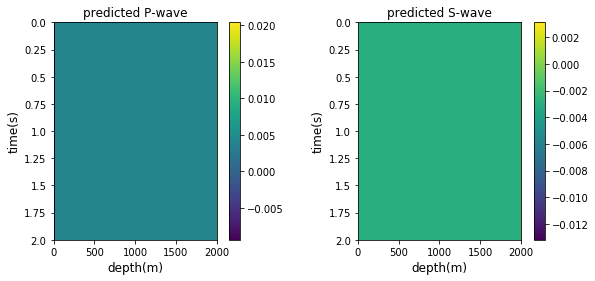

In [50]:
## plot y_predict
from matplotlib.ticker import MultipleLocator
lines = 1
cols = 2
forts = 12
ss1 = 300
ss2 = 400

x_libs = [0,0, 500, 1000, 1500, 2000]#np.linspace(0,1500,4)#[0, 500, 1000, 1500]
y_libs = np.linspace(0,2,9)#[0,0.4, 0.8, 1.2, 1.6, 2]

fig, axs = plt.subplots(1,2,figsize=(10, 4), sharey=True)

# obj = 'y_predict'
# im = plt.imshow(eval(obj)[0,:,:,1], extent=[0, 512, 512,0])
# plt.colorbar(im)

# ax1 = plt.subplot(131)
ax1 = plt.subplot(lines,cols,1)
obj = 'y_predict'
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(eval(obj)[0,:,:,0], extent=[0, ss1, ss2,0])
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("predicted P-wave", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax1.xaxis.set_major_locator(MultipleLocator(75))
ax1.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax1.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax1.get_xticklabels(), fontsize=10);
# plt.tight_layout()

# ax1 = plt.subplot(131)
ax2 = plt.subplot(lines,cols,2)
obj = 'y_predict'
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(eval(obj)[0,:,:,1], extent=[0, ss1, ss2,0])
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("predicted S-wave", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax2.xaxis.set_major_locator(MultipleLocator(75))
ax2.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax2.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax2.get_xticklabels(), fontsize=10);
# plt.tight_layout()

